## Description:

This file contains:
* **Cluster at individual IAB level and analyze results**

In [1]:
""" Helper imports"""
import re
import joblib
import pandas as pd
import numpy as np
from time import time
from nltk.tokenize import sent_tokenize
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import cosine_similarity

"""Modeling imports"""
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from hdbscan import validity_index

""" Plotting imports"""
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# remove this later
pd.set_option('max_colwidth', 110)
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
# add the parent directory path
sys.path.insert(0, '..')

from src.util import (c_tf_idf, 
                      extract_top_n_words_per_topic,
                      extract_topic_sizes,
                      topic_cos_sim_metrics,
                      generate_all_cossim_metrics)

In [4]:
data_path = '/home/jupyter/bi-topic-modeling/data/' 

STOP_WORDS = pd.read_pickle(data_path + 'forbes_stop_words.pkl')
"q1" in STOP_WORDS

True

In [5]:
results_path = '/home/jupyter/bi-topic-modeling/results/' 
SEED = 42

### --- Data ---

* Train date range Apr 26 (monday) till May 02 (sunday)
* Eligible pool = articles with pvs > 100 on a given day

In [6]:
def get_data(file_name):
    
    df = pd.read_csv(data_path + file_name)

    print("Before Shape:", df.shape)
    print("Unique tiers:", len(df.tier1.unique()))
    
    # Per verdict from EDA, exclude articles less than 100 words
    df["article_length"] = df.clean_body.str.split().apply(len)
    df = df[df["article_length"]>=100]
    print("After Shape:", df.shape)
    
    df.tier1 = df.tier1.fillna('Other')
    df = df.reset_index(drop=True)
    
    return df

In [7]:
# training data set

print("--- apr 25 ---")
apr25 = get_data('processed/train_apr25_over100pvs_processed.csv')
apr25_art_embed = joblib.load("./data/processed/apr25_article_embed_axis0.joblib")
print("Embeds len:", len(apr25_art_embed))

print()
print("--- apr 26 ---")
apr26 = get_data('processed/pred_apr26_over100pvs_processed.csv')
apr26_art_embed = joblib.load("./data/processed/apr26_article_embed_axis0.joblib")
print("Embeds len:", len(apr26_art_embed))

print()
print("--- apr 27 ---")
apr27 = get_data('processed/pred_apr27_over100pvs_processed.csv')
apr27_art_embed = joblib.load("./data/processed/apr27_article_embed_axis0.joblib")
print("Embeds len:", len(apr27_art_embed))

print()
print("--- apr 28 ---")
apr28 = get_data('processed/apr28_over100pvs_processed.csv')
apr28_art_embed = joblib.load("./data/processed/apr28_article_embed_axis0.joblib")
print("Embeds len:", len(apr28_art_embed))

print()
print("--- apr 29 ---")
apr29 = get_data('processed/apr29_over100pvs_processed.csv')
apr29_art_embed = joblib.load("./data/processed/apr29_article_embed_axis0.joblib")
print("Embeds len:", len(apr29_art_embed))

print()
print("--- apr 30 ---")
apr30 = get_data('processed/apr30_over100pvs_processed.csv')
apr30_art_embed = joblib.load("./data/processed/apr30_article_embed_axis0.joblib")
print("Embeds len:", len(apr30_art_embed))

print("--- may 01 ---")
may01 = get_data('processed/may01_over100pvs_processed.csv')
may01_art_embed = joblib.load("./data/processed/may01_article_embed_axis0.joblib")
print("Embeds len:", len(may01_art_embed))

print()
print("--- may 02 ---")
may02 = get_data('processed/may02_over100pvs_processed.csv')
may02_art_embed = joblib.load("./data/processed/may02_article_embed_axis0.joblib")
print("Embeds len:", len(may02_art_embed))

--- apr 25 ---
Before Shape: (3334, 10)
Unique tiers: 31
After Shape: (3327, 11)
Embeds len: 3327

--- apr 26 ---
Before Shape: (4138, 10)
Unique tiers: 31
After Shape: (4128, 11)
Embeds len: 4128

--- apr 27 ---
Before Shape: (4177, 10)
Unique tiers: 31
After Shape: (4167, 11)
Embeds len: 4167

--- apr 28 ---
Before Shape: (4197, 8)
Unique tiers: 31
After Shape: (4186, 9)
Embeds len: 4186

--- apr 29 ---
Before Shape: (4201, 8)
Unique tiers: 31
After Shape: (4188, 9)
Embeds len: 4188

--- apr 30 ---
Before Shape: (3784, 8)
Unique tiers: 31
After Shape: (3771, 9)
Embeds len: 3771
--- may 01 ---
Before Shape: (3052, 8)
Unique tiers: 31
After Shape: (3044, 9)
Embeds len: 3044

--- may 02 ---
Before Shape: (3267, 8)
Unique tiers: 31
After Shape: (3259, 9)
Embeds len: 3259


In [8]:
# testing data set

print()
print("--- may 03 ---")
may03 = get_data('processed/may03_over100pvs_processed.csv')
may03_art_embed = joblib.load("./data/processed/may03_article_embed_axis0.joblib")
print("Embeds len:", len(may03_art_embed))

print()
print("--- may 04 ---")
may04 = get_data('processed/may04_over100pvs_processed.csv')
may04_art_embed = joblib.load("./data/processed/may04_article_embed_axis0.joblib")
print("Embeds len:", len(may04_art_embed))

print()
print("--- may 05 ---")
may05 = get_data('processed/may05_over100pvs_processed.csv')
may05_art_embed = joblib.load("./data/processed/may05_article_embed_axis0.joblib")
print("Embeds len:", len(may05_art_embed))

print("--- may 06 ---")
may06 = get_data('processed/may06_over100pvs_processed.csv')
may06_art_embed = joblib.load("./data/processed/may06_article_embed_axis0.joblib")
print("Embeds len:", len(may06_art_embed))

print("--- may 07 ---")
may07 = get_data('processed/may07_over100pvs_processed.csv')
may07_art_embed = joblib.load("./data/processed/may07_article_embed_axis0.joblib")
print("Embeds len:", len(may07_art_embed))


--- may 03 ---
Before Shape: (4210, 8)
Unique tiers: 31
After Shape: (4199, 9)
Embeds len: 4199

--- may 04 ---
Before Shape: (4235, 8)
Unique tiers: 31
After Shape: (4223, 9)
Embeds len: 4223

--- may 05 ---
Before Shape: (4174, 8)
Unique tiers: 31
After Shape: (4160, 9)
Embeds len: 4160
--- may 06 ---
Before Shape: (4079, 8)
Unique tiers: 31
After Shape: (4063, 9)
Embeds len: 4063
--- may 07 ---
Before Shape: (3644, 8)
Unique tiers: 31
After Shape: (3630, 9)
Embeds len: 3630


* Combine train data - 7 days: apr 26 (monday) till may 2 (sunday)

In [9]:
# concatenate dfs
combined_df = pd.concat([apr26, apr27, apr28, apr29, apr30, may01, may02])

# reset index
combined_df = combined_df.reset_index(drop=True)

# drop unnecessary cols
combined_df.drop(["processed", "processed_noun", "processed_noun_2"], axis = 1, inplace=True)

# fill na
combined_df.tier2 = combined_df.tier2.fillna('Other')
combined_df.total_timeonpage = combined_df.total_timeonpage.fillna(0)
print(combined_df.shape)

# concatenate embeds
combined_embeds = apr26_art_embed + apr27_art_embed + apr28_art_embed + apr29_art_embed + apr30_art_embed + may01_art_embed + may02_art_embed
print(len(combined_embeds))

(26743, 9)
26743


In [10]:
# to get metrics for training weeks unique 7238 articles summed over 7 days

# test = combined_df.groupby('content_natid').agg({'pvs':'sum', 'pub_date':'max',
#                                                  'article_length':'max', 
#                                                  'total_timeonpage':'sum'}).reset_index()

# temp = pd.merge(test, combined_df[["content_natid", "pub_date", "article_length", "title", "tier1", "tier2", "clean_body"]], 
#          on = ["content_natid", "pub_date", "article_length"], how="inner").drop_duplicates(subset='content_natid',
#                                                                                             keep='first')

# repeating example - 'Robot Vacuums That Clean'

In [10]:
# drop duplicates from df

train_df = combined_df.drop_duplicates(subset="content_natid", keep='first')

print(train_df.shape)
print(train_df.content_natid.duplicated(keep='first').any())

train_embeds =  [combined_embeds[i] for i in list(train_df.index)]
print(len(train_embeds))

(7238, 9)
False
7238


In [11]:
train_df.reset_index(drop=True, inplace=True)

train_df = train_df[['content_natid', 'clean_body', 'tier1']]
train_df.shape

(7238, 3)

### --- Modeling ---

In [12]:
data = train_df.clean_body.tolist()
print(len(data))

7238


**Param settings:** Params were updated in two rounds for reducing noise:
1. 1st round - NEW SETTINGS for lesser noise - umap:n_neighbors=15, n_components=2, min_dist=0.0 
    * hdbscan min_cluster_size=5, input = sentence embeddings aggregated (mean) to full article were kept the same
2. 2nd round - NEW SETTINGS for lesser noise - additionally took min_samples = 4 (umap updated params from bullet 1 were used)
    * Manual observation on trained data (1week apr 26 to may2)- 
        * 5 topics with previous noise articles inspected, 3 were yellow 1 was red, 1 green 
        * But comparing 5 previous noise articles , only 1 was bad other 4 got correct labels
    * Manual observation on predicted May03 data - Out of 23 matching topics, bad 13 good 10 with min_sample compared to round 1

| 1st round      | 2nd round |
| ----------- | ----------- |
| Trained topics 277      | Trained topics 323       |
| Trained noise  30% | Trained noise 27% <br>(200 previous noise articles were clustered)       |
| Pred May03 topics 260      | Pred May03 topics  310       |
| Pred May03 noise  44% (1835)| Pred May03 noise 42% (1784)<br>(50 previous noise articles were clustered)       |
| DBCV 0.327      | DBCV 0.299     |

Based on manual observation and numbers above, decided to go with 2nd round params

In [13]:
# NEW SETTINGS for lesser noise - umap:n_neighbors=15, n_components=2, min_dist=0.0 
# hdbscan min_cluster_size=5, min_samples = 4, input = sentence embeddings aggregated (mean) to full article

umap_embeddings =  umap.UMAP(n_neighbors=15,
                             min_dist=0.0,
                             n_components=2,
                             random_state=SEED,
                            ).fit(train_embeds)

In [14]:
# cluster
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                      min_samples = 4, #new
                      metric= 'euclidean',                      
                      cluster_selection_method='eom',
                      prediction_data=True).fit(umap_embeddings.embedding_)

In [15]:
print("Shape of training embeddings:", umap_embeddings.embedding_.shape)

Shape of training embeddings: (7238, 2)


In [16]:
labels = cluster.labels_
print("Settings - mean axis=0")
validity_index(umap_embeddings.embedding_.astype('double'), labels)

Settings - mean axis=0


0.2996882715864831

In [17]:
# put topics in dataframe
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

print("Distinct topics including -1 for noise", len(docs_df.Topic.unique()))
print()
docs_df

Distinct topics including -1 for noise 323



,Doc,Topic,Doc_ID
0,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list ...",-1,0
1,these 11 mattress toppers give you the bed of your dreams. while new pillows or a new set of sheets can do...,46,1
2,"wayfairs biggest sale of the year is officially here. thanks to the pandemic, most of us have spent the pa...",56,2
3,apple ios 14.5 released: massive iphone update with cool features & important fixes. april 28 update below...,60,3
4,apple airtag: all you need to know about the game-changing new gadget. april 28 update below. this post wa...,60,4
...,...,...,...
7233,"the oilman, the playmate, and the tangled affairs of the billionaire marshall family. j. howard marshall i...",132,7233
7234,5 surprising foods that help you sleep. cherries: the new melatonin supplement (image via wikipedia) june ...,35,7234
7235,hacker's demo shows how easily credit cards can be read through clothes and wallets. some blank credit car...,44,7235
7236,"the five richest pastors in nigeria. london-based nigerian pastor matthew ashimolowo god is good, especial...",187,7236


In [18]:
# combine together all articles belonging to same cluster  
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

# calculate countVector and tf-idf
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

# top n words, topic size
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 

# modify top_n_words per topic dict into dataframe for presentation
topic_words_dict = {}  

for k, v in top_n_words.items():
    topic_words_dict[k] = ", ".join([elem[0] for elem in v])

pd.set_option("max_colwidth", 250)
top_n_words_df = pd.DataFrame.from_dict(topic_words_dict, 
                                        orient='index').reset_index().rename(columns={'index':'topic_num',
                                                                                      
                                                                                      0:'topic_words'}) 

In [19]:
# clean keywords

from collections import OrderedDict
# from fuzzywuzzy import process, fuzz
from itertools import chain

import time
start = time.time()

clean_keys = []
for index, row in top_n_words_df.iterrows(): 
    
    # remove STOP WORDS and remove whitespaces
    inter_list = [x.strip() for x in row["topic_words"].split(",") if x not in STOP_WORDS]
    
    # remove numbers but not alphanumerics e.g. remove 400, not ps4 
    inter_list = [x for x in inter_list if not x.isnumeric()]
    
    # remove subset-based similar words - e.g. 'pcr tests' and 'tests' then 'tests' will be removed
    inter_list = [i for i in inter_list if not any(i in x and i!=x for x in inter_list)]

    # remove empty or 1-letter words
    inter_list = [x for x in inter_list if len(x)>1]
    
    # de-duplicate
    inter_list = list(OrderedDict.fromkeys(inter_list))
    
    # keep top 20 cleaned keywords
    inter_list = inter_list[:6] 
    
    # convert into string
    inter_list = ', '.join(inter_list)
    
    clean_keys.append(inter_list)

end = time.time()
print("keyword time", (end - start)/60) 

keyword time 0.0005671302477518718


In [20]:
top_n_words_df["topic_words"] = clean_keys

In [21]:
# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
train_cossim_df = generate_all_cossim_metrics(docs_df, train_embeds)

# per topic - tier counts
tier_metric = docs_df.join(train_df[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info = pd.merge(pd.merge(pd.merge(top_n_words_df, 
                               topic_sizes, how="inner", left_on="topic_num", right_on = "Topic"), 
                               train_cossim_df, on = "topic_num", how="inner"), 
                      iab_metric, on = "topic_num", how="inner")

topic_info.drop('Topic', axis=1, inplace=True)

In [22]:
topic_info.head()

,topic_num,topic_words,Size,cos_min,cos_mean,distinct_tier1s
0,-1,"remote, age, businesses, leaders, workers, water",1946,-0.05,0.71,31
1,0,"10 states, average annual, annual wage, salaries, occupational, therapist salary",34,0.77,0.90,8
2,1,"million viewers, 000 viewers, fox news, msnbc, cable news, prime time",7,0.95,0.97,3
3,2,"pink moon, sky, supermoons, super pink, sun, blood moon",30,0.75,0.88,6
4,3,"def, aew, nxt, wrestlemania, smackdown, live events",14,0.76,0.88,4


* Observation on cluter-goodness:
    * Good quality overall - 
        * most articles in a group on avg have 0.85-0.93 cosine similarity which is pretty high
        * min similarity is also 0.7 and above for most topics
        
    * Manual eyeballing - 88 topics good, 19 bad

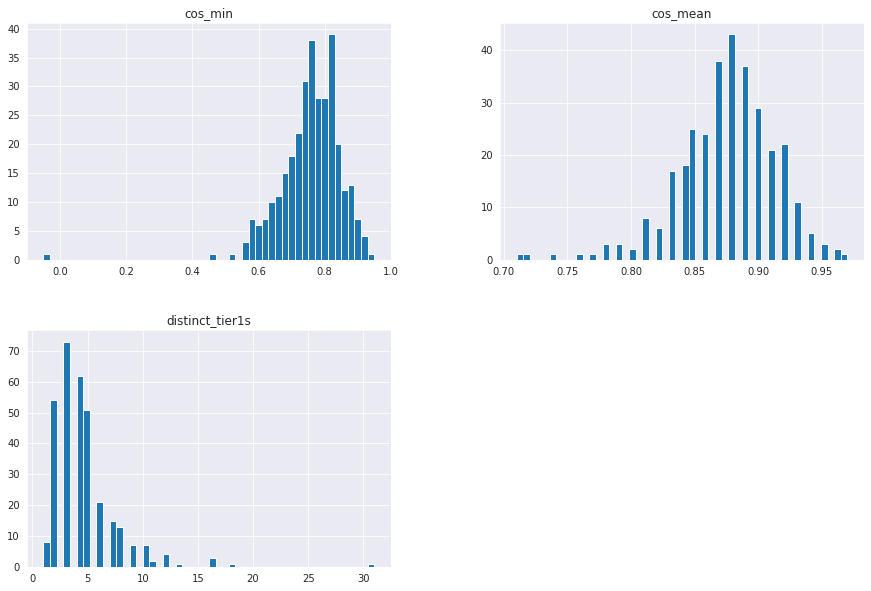

In [23]:
# TEST FOR LESSER NOISE
topic_info[['cos_min', 'cos_mean', 'distinct_tier1s']].hist(figsize= (15,10), bins=50)
plt.show()

In [24]:
joblib.dump(umap_embeddings, "./model/apr26_may2_train_umap_obj.joblib")
joblib.dump(cluster, "./model/apr26_may2_train_clusterer_obj.joblib")

['./model/apr26_may2_train_clusterer_obj.joblib']

**Topics are about:**


In [25]:
# combine natural id inside docs_df
docs_df = pd.merge(docs_df, train_df, how="left", left_on="Doc", right_on="clean_body")
docs_df.drop("clean_body", axis=1, inplace=True)

In [26]:
# contains natid, article body, assigned topic

full_train_topics = pd.merge(docs_df, topic_info, how="left", left_on="Topic", right_on="topic_num")
full_train_topics.head(1)

,Doc,Topic,Doc_ID,content_natid,tier1,topic_num,topic_words,Size,cos_min,cos_mean,distinct_tier1s
0,"10 robot vacuums that clean so you dont have to. if youre like most people, vacuuming is low on your list of favorite chores. you can avoid cleaning, or enlist the aid of a robot vacuum to clean your home autonomously. the best robot vacuums are ...",-1,0,blogandpostid/blog/post/4983-5ea87d15960ddf000681c604,Shopping,-1,"remote, age, businesses, leaders, workers, water",1946,-0.05,0.71,31


In [29]:
# full_train_topics.to_csv(results_path+"apr26_may02_full_train_topics.csv", index=False)

In [37]:
# TEST FOR LESSER NOISE
full_train_topics.to_csv(results_path+"review_apr26_may02_trained_topics.csv", index=False)

In [35]:
# trained size 
topic_info.Size.describe()

count     323.000000
mean       22.408669
std       108.579164
min         5.000000
25%         7.000000
50%        11.000000
75%        19.000000
max      1946.000000
Name: Size, dtype: float64

<AxesSubplot:>

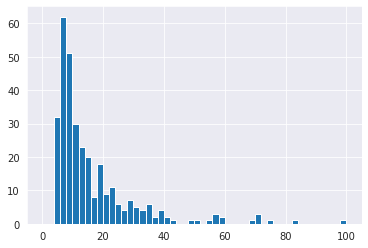

In [36]:
# trained size hist
topic_info.Size.hist(bins=50, range=(0,100))

In [ ]:
# trained topics = 323. Noise = 27% (1946/7238)

* **Predict new points/articles - May 3**

In [27]:
# umap_embeddings = joblib.load("./model/apr26_may2_train_umap_obj.joblib")
# cluster = joblib.load("./model/apr26_may2_train_clusterer_obj.joblib")

print(umap_embeddings)
print()
print(cluster)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.0, random_state=42)

HDBSCAN(min_samples=4, prediction_data=True)


**Note:** 
* There will be articles read between Apr 26 - May 02 (training set), which will also be read on May 03. 
* These common articles present in prediction set, will get the same topic cluster as before

**For now:**
* Predict on whole of may03

In [28]:
# dimensionality reduction
umap_embeddings_may03 = umap_embeddings.transform(may03_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may03.shape) #takes a min

Training input shape: (7238, 2)
Prediction input shape: (4199, 2)


In [29]:
# predict

may03_test_labels, may03_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may03)

print(len(may03_test_labels))
print(len(set(may03_test_labels)))

4199
310


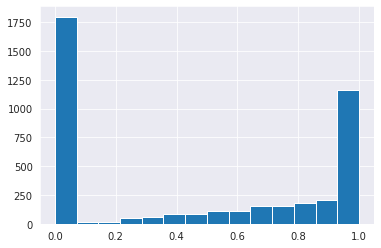

In [30]:
plt.hist(may03_strengths, bins='auto')
plt.show()

* Exploring prediction strength for thresholding

In [31]:
print(len(may03_test_labels))
print(len(may03_strengths))
print(type(may03_strengths))

4199
4199
<class 'numpy.ndarray'>


In [32]:
# put topics in dataframe
may03_docs_df = may03[['clean_body']]
may03_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may03_docs_df["Topic"] = may03_test_labels

print("Distinct topics including -1 for noise", len(may03_docs_df.Topic.unique()))
print()
may03_docs_df.tail()

Distinct topics including -1 for noise 310



,Doc,Topic
4194,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1
4195,"mark zuckerberg joins the north american man-boy love association, and other adventures in facebook groups. my colleague kashmir hill congratulated facebook's mark zuckerberg earlier today on his increasingly savvy approach to talking about priva...",44
4196,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",243
4197,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,-1
4198,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",190


In [33]:
may03_topic_sizes = extract_topic_sizes(may03_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may03_cossim_df = generate_all_cossim_metrics(may03_docs_df, umap_embeddings_may03)

# per topic - tier counts
tier_metric = may03_docs_df.join(may03[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may03 = pd.merge(pd.merge(may03_topic_sizes, 
                                        may03_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may03.drop('Topic', axis=1, inplace=True)

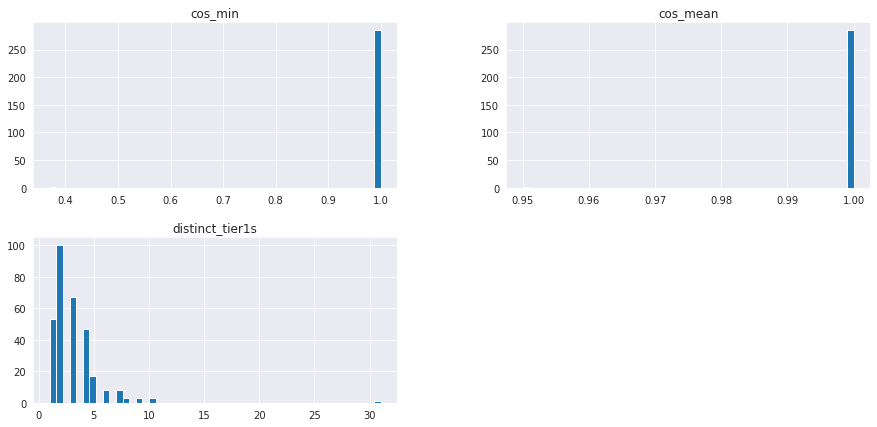

In [34]:
# TEST FOR LESSER NOISE
topic_info_may03[['cos_min', 'cos_mean', 'distinct_tier1s']].hist(figsize= (15,7), bins=50)
plt.show()

In [35]:
# combine natural id inside docs_df

may03_docs_df = pd.merge(may03_docs_df, may03, how="left", left_on="Doc", right_on="clean_body")
may03_docs_df.drop("clean_body", axis=1, inplace=True)

In [36]:
# combine topic_info_may03 with topic names

topic_info_may03 = pd.merge(topic_info_may03, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [37]:
pred_may03_inspect = pd.merge(may03_docs_df, 
         topic_info_may03, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

In [38]:
topic_info_may03.Size.describe()

count     310.000000
mean       13.545161
std       101.228807
min         1.000000
25%         3.000000
50%         5.000000
75%         9.000000
max      1784.000000
Name: Size, dtype: float64

<AxesSubplot:>

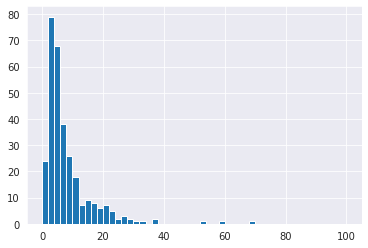

In [39]:
topic_info_may03.Size.hist(bins=50, range=(0, 100))

In [40]:
print(len(pred_may03_inspect.Topic.unique()))
print(pred_may03_inspect[pred_may03_inspect.Topic==-1].shape)

310
(1784, 15)


In [41]:
# TEST FOR LESSER NOISE
pred_may03_inspect.to_csv(results_path + "MOD_may03pred_7daytrain.csv", index=False)

In [51]:
# TEST FOR LESSER NOISE
pred_may03_inspect.to_csv(results_path+"review_may03_predicted_topics.csv", index=False)

* **Predict new points/articles - May 04**

In [42]:
# dimensionality reduction
umap_embeddings_may04 = umap_embeddings.transform(may04_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may04.shape) #takes a min

Training input shape: (7238, 2)
Prediction input shape: (4223, 2)


In [43]:
# predict

may04_test_labels, may04_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may04)

print(len(may04_test_labels))
# print(set(may04_test_labels))
print(len(set(may04_test_labels)))

4223
298


In [44]:
# put topics in dataframe
may04_docs_df = may04[['clean_body']]
may04_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may04_docs_df["Topic"] = may04_test_labels

print("Distinct topics including -1 for noise", len(may04_docs_df.Topic.unique()))
print()
may04_docs_df.tail()

Distinct topics including -1 for noise 298



,Doc,Topic
4218,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1
4219,"how many olympic-sized swimming pools can we fill with billionaire gold?. gold has been in the spotlight for a while now. from hovering around $300 a troy ounce in the early part of the last decade, the precious metal has more than quadrupled in ...",198
4220,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",-1
4221,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,-1
4222,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",190


In [45]:
may04_topic_sizes = extract_topic_sizes(may04_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may04_cossim_df = generate_all_cossim_metrics(may04_docs_df, umap_embeddings_may04)

# per topic - tier counts
tier_metric = may04_docs_df.join(may04[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may04 = pd.merge(pd.merge(may04_topic_sizes, 
                                        may04_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may04.drop('Topic', axis=1, inplace=True)

In [46]:
# topic_info_may03[['cos_min', 'cos_mean', 'distinct_tier1s']].hist(figsize= (15,7))
# plt.show()

In [47]:
# combine natural id inside docs_df

may04_docs_df = pd.merge(may04_docs_df, may04, how="left", left_on="Doc", right_on="clean_body")
may04_docs_df.drop("clean_body", axis=1, inplace=True)

# combine topic_info_may04 with topic names

topic_info_may04 = pd.merge(topic_info_may04, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [48]:
pred_may04_inspect = pd.merge(may04_docs_df, 
         topic_info_may04, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

pred_may04_inspect.head(1)

,Doc,Topic,pvs,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words
0,"10 durable air mattresses that wont go flat on you overnight. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone whos ever...",47,214,35648,blogandpostid/blog/post/4983-603fce6d28b0df00061a762b,2021-06-08,10 Durable Air Mattresses That Won’t Go Flat On You Overnight,Home & Garden,NaN,2104,13,1.0,1.0,3,"memory foam, sleepers, neck pain, foam pillow, pillows, foam mattress"


In [58]:
# TEST FOR LESSER NOISE
pred_may03_inspect.to_csv(results_path+"review_may04_predicted_topics.csv", index=False)

In [49]:
# TEST FOR LESSER NOISE
pred_may04_inspect.to_csv(results_path + "MOD_may04pred_7daytrain.csv", index=False)

* **Predict new points/articles - May 05**

In [50]:
# dimensionality reduction
umap_embeddings_may05 = umap_embeddings.transform(may05_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may05.shape) #takes a min

Training input shape: (7238, 2)
Prediction input shape: (4160, 2)


In [51]:
# predict

may05_test_labels, may05_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may05)

print(len(may05_test_labels))
# print(set(may05_test_labels))
print(len(set(may05_test_labels)))

4160
311


In [52]:
# put topics in dataframe
may05_docs_df = may05[['clean_body']]
may05_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may05_docs_df["Topic"] = may05_test_labels

print("Distinct topics including -1 for noise", len(may05_docs_df.Topic.unique()))
print()
may05_docs_df.tail()

Distinct topics including -1 for noise 311



,Doc,Topic
4155,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",118
4156,"mark zuckerberg joins the north american man-boy love association, and other adventures in facebook groups. my colleague kashmir hill congratulated facebook's mark zuckerberg earlier today on his increasingly savvy approach to talking about priva...",44
4157,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",243
4158,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,77
4159,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",190


In [53]:
may05_topic_sizes = extract_topic_sizes(may05_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may05_cossim_df = generate_all_cossim_metrics(may05_docs_df, umap_embeddings_may05)

# per topic - tier counts
tier_metric = may05_docs_df.join(may05[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may05 = pd.merge(pd.merge(may05_topic_sizes, 
                                        may05_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may05.drop('Topic', axis=1, inplace=True)

In [54]:
# combine natural id inside docs_df

may05_docs_df = pd.merge(may05_docs_df, may05, how="left", left_on="Doc", right_on="clean_body")
may05_docs_df.drop("clean_body", axis=1, inplace=True)

# combine topic_info_may03 with topic names

topic_info_may05 = pd.merge(topic_info_may05, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [55]:
pred_may05_inspect = pd.merge(may05_docs_df, 
         topic_info_may05, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

pred_may05_inspect.head(1)

,Doc,Topic,pvs,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words
0,"10 durable air mattresses that wont go flat on you overnight. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone whos ever...",47,185,28901,blogandpostid/blog/post/4983-603fce6d28b0df00061a762b,2021-06-08,10 Durable Air Mattresses That Won’t Go Flat On You Overnight,Home & Garden,NaN,2104,14,1.0,1.0,3,"memory foam, sleepers, neck pain, foam pillow, pillows, foam mattress"


In [66]:
# pred_may05_inspect.to_csv(results_path + "may05pred_7daytrain.csv", index=False)

In [56]:
# TEST FOR LESSER NOISE
pred_may05_inspect.to_csv(results_path + "MOD_may05pred_7daytrain.csv", index=False)

* **Predict new points/articles - May 06**

In [57]:
# dimensionality reduction
umap_embeddings_may06 = umap_embeddings.transform(may06_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may06.shape) #takes a min

Training input shape: (7238, 2)
Prediction input shape: (4063, 2)


In [58]:
# predict

may06_test_labels, may06_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may06)

print(len(may06_test_labels))
print(len(set(may06_test_labels)))

4063
292


In [59]:
# put topics in dataframe
may06_docs_df = may06[['clean_body']]
may06_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may06_docs_df["Topic"] = may06_test_labels

print("Distinct topics including -1 for noise", len(may06_docs_df.Topic.unique()))
print()
may06_docs_df.tail()

Distinct topics including -1 for noise 292



,Doc,Topic
4058,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1
4059,"mark zuckerberg joins the north american man-boy love association, and other adventures in facebook groups. my colleague kashmir hill congratulated facebook's mark zuckerberg earlier today on his increasingly savvy approach to talking about priva...",44
4060,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",-1
4061,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,-1
4062,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",-1


In [60]:
may06_topic_sizes = extract_topic_sizes(may06_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may06_cossim_df = generate_all_cossim_metrics(may06_docs_df, umap_embeddings_may06)

# per topic - tier counts
tier_metric = may06_docs_df.join(may06[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may06 = pd.merge(pd.merge(may06_topic_sizes, 
                                        may06_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may06.drop('Topic', axis=1, inplace=True)

In [61]:
# combine natural id inside docs_df

may06_docs_df = pd.merge(may06_docs_df, may06, how="left", left_on="Doc", right_on="clean_body")
may06_docs_df.drop("clean_body", axis=1, inplace=True)

# combine topic_info_may03 with topic names

topic_info_may06 = pd.merge(topic_info_may06, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [62]:
pred_may06_inspect = pd.merge(may06_docs_df, 
         topic_info_may06, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

pred_may06_inspect.head(1)

,Doc,Topic,pvs,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words
0,"11 top-rated mattresses that will give you the best sleep of your life. a good mattress is a necessity. it keeps you comfortable at night, supports your joints while you sleep and provides a welcome resting place when youre just lounging in bed. ...",-1,2842,411858,blogandpostid/blog/post/4983-60086702e0ca9e00079de673,2021-06-10,11 Top-Rated Mattresses That Will Give You The Best Sleep Of Your Life,Home & Garden,Interior Decorating,3016,1950,0.34,0.94,31,"remote, age, businesses, leaders, workers, water"


In [63]:
pred_may06_inspect.shape

(4063, 15)

In [64]:
# TEST FOR LESSER NOISE
pred_may06_inspect.to_csv(results_path + "MOD_may06pred_7daytrain.csv", index=False)

* **Predict new points/articles - May 07**

In [65]:
# dimensionality reduction
umap_embeddings_may07 = umap_embeddings.transform(may07_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may07.shape) #takes a min

Training input shape: (7238, 2)
Prediction input shape: (3630, 2)


In [66]:
# predict

may07_test_labels, may07_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may07)

print(len(may07_test_labels))
print(len(set(may07_test_labels)))

3630
287


In [67]:
# put topics in dataframe
may07_docs_df = may07[['clean_body']]
may07_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may07_docs_df["Topic"] = may07_test_labels

print("Distinct topics including -1 for noise", len(may07_docs_df.Topic.unique()))
print()
may07_docs_df.tail()

Distinct topics including -1 for noise 287



,Doc,Topic
3625,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1
3626,"mark zuckerberg joins the north american man-boy love association, and other adventures in facebook groups. my colleague kashmir hill congratulated facebook's mark zuckerberg earlier today on his increasingly savvy approach to talking about priva...",44
3627,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",243
3628,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,-1
3629,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",190


In [68]:
may07_topic_sizes = extract_topic_sizes(may07_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may07_cossim_df = generate_all_cossim_metrics(may07_docs_df, umap_embeddings_may07)

# per topic - tier counts
tier_metric = may07_docs_df.join(may07[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may07 = pd.merge(pd.merge(may07_topic_sizes, 
                                        may07_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may07.drop('Topic', axis=1, inplace=True)

In [69]:
# combine natural id inside docs_df

may07_docs_df = pd.merge(may07_docs_df, may07, how="left", left_on="Doc", right_on="clean_body")
may07_docs_df.drop("clean_body", axis=1, inplace=True)

# combine topic_info_may03 with topic names

topic_info_may07 = pd.merge(topic_info_may07, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [70]:
pred_may07_inspect = pd.merge(may07_docs_df, 
         topic_info_may07, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

pred_may07_inspect.head(1)

,Doc,Topic,pvs,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words
0,"the best sales online right now: tatcha, best buy and more. summer doesnt officially start until june 20but thats not stopping retailers from releasing seasonal savings events. a slew of brands are either holding summer sales or offering fathers ...",53,2433,135477,blogandpostid/blog/post/4983-5f91fc0b22d6b000067a24d4,2021-06-11,"The Best Sales Online Right Now: Tatcha, Best Buy and More",Shopping,Sales and Promotions,1318,4,1.0,1.0,2,"flash deals, bedding, way day, mattresses, sale, save"


In [71]:
pred_may07_inspect.shape

(3630, 15)

In [72]:
# TEST FOR LESSER NOISE
pred_may07_inspect.to_csv(results_path + "MOD_may07pred_7daytrain.csv", index=False)

--Below--:
* Compared noise perc for 5 days out prediction using same model
* Assigned topic-scores for 5 days and visualized it + pvs 

**Learning** - below I have made an obs that training articles are present in prediction set and they will get same topic. I could have gone one step further here itself and thought about day-over-day prediction set articles being same and check if they get same topic? By doing this - I would have found out early that already-predicted ones sometimes erroneously get marked as noise so they dont need to be predicted on again. 

### --- Noise Comparison ---

In [7]:
print("Eligible articles:")
print("May 3 -", pred_may03_inspect.shape)
print("May 4 -", pred_may04_inspect.shape)
print("May 5 -", pred_may05_inspect.shape)
print("May 6 -", pred_may06_inspect.shape)
print("May 7 -", pred_may07_inspect.shape)

Eligible articles:
May 3 - (4199, 15)
May 4 - (4223, 15)
May 5 - (4160, 15)
May 6 - (4063, 15)
May 7 - (3630, 15)


In [8]:
print("Number of Topics assigned:")
print("May 3 -",len(pred_may03_inspect.Topic.unique()))
print("May 4 -",len(pred_may04_inspect.Topic.unique()))
print("May 5 -",len(pred_may05_inspect.Topic.unique()))
print("May 6 -",len(pred_may06_inspect.Topic.unique()))
print("May 7 -",len(pred_may07_inspect.Topic.unique()))

Number of Topics assigned:
May 3 - 310
May 4 - 298
May 5 - 311
May 6 - 292
May 7 - 287


In [9]:
print("May 3 -")
print(pred_may03_inspect[pred_may03_inspect.Topic==-1].shape)
print(pred_may03_inspect.shape)

May 3 -
(1784, 15)
(4199, 15)


In [10]:
print("Perc of articles NOISE - ")
print("May 3 -",round(pred_may03_inspect[pred_may03_inspect.Topic==-1].shape[0]/pred_may03_inspect.shape[0]*100))
print("May 4 -",round(pred_may04_inspect[pred_may04_inspect.Topic==-1].shape[0]/pred_may04_inspect.shape[0]*100))
print("May 5 -",round(pred_may05_inspect[pred_may05_inspect.Topic==-1].shape[0]/pred_may05_inspect.shape[0]*100))
print("May 6 -",round(pred_may06_inspect[pred_may06_inspect.Topic==-1].shape[0]/pred_may06_inspect.shape[0]*100))
print("May 7 -",round(pred_may07_inspect[pred_may07_inspect.Topic==-1].shape[0]/pred_may07_inspect.shape[0]*100))

Perc of articles NOISE - 
May 3 - 42
May 4 - 47
May 5 - 43
May 6 - 48
May 7 - 46


In [11]:
apr26_may03_df = pd.read_csv(results_path+"review_apr26_may02_trained_topics.csv")
apr26_may03_df.shape

(7238, 15)

In [16]:
may03_noise = pred_may03_inspect[pred_may03_inspect.Topic==-1]
print(may03_noise.shape)
may04_noise = pred_may04_inspect[pred_may04_inspect.Topic==-1]
print(may04_noise.shape)
may05_noise = pred_may05_inspect[pred_may05_inspect.Topic==-1]
print(may05_noise.shape)
may06_noise = pred_may06_inspect[pred_may06_inspect.Topic==-1]
print(may06_noise.shape)
may07_noise = pred_may07_inspect[pred_may07_inspect.Topic==-1]
print(may07_noise.shape)

(1784, 15)
(1964, 15)
(1797, 15)
(1950, 15)
(1676, 15)


In [19]:
print(may03_noise[may03_noise.content_natid.isin(apr26_may03_df[apr26_may03_df.Topic==-1].content_natid)].shape)
print(may04_noise[may04_noise.content_natid.isin(apr26_may03_df[apr26_may03_df.Topic==-1].content_natid)].shape)
print(may05_noise[may05_noise.content_natid.isin(apr26_may03_df[apr26_may03_df.Topic==-1].content_natid)].shape)
print(may06_noise[may06_noise.content_natid.isin(apr26_may03_df[apr26_may03_df.Topic==-1].content_natid)].shape)
print(may07_noise[may07_noise.content_natid.isin(apr26_may03_df[apr26_may03_df.Topic==-1].content_natid)].shape)

(791, 15)
(744, 15)
(679, 15)
(670, 15)
(576, 15)


In [24]:
print("Actual noise")
print("May 3 -",round((may03_noise.shape[0] - may03_noise[may03_noise.content_natid.isin(apr26_may03_df[apr26_may03_df.Topic==-1].content_natid)].shape[0])/pred_may03_inspect.shape[0]*100))

Actual noise
May 3 - 24


### --- Topic Scoring ---

* Data - May 03 eligible articles and their assigned topics

In [6]:
# topic assignment

print("---full dfs---")
# may 03
pred_may03_inspect = pd.read_csv(results_path + "MOD_may03pred_7daytrain.csv")
print(pred_may03_inspect.shape)
# may 04
pred_may04_inspect = pd.read_csv(results_path + "MOD_may04pred_7daytrain.csv")
print(pred_may04_inspect.shape)
# may 05
pred_may05_inspect = pd.read_csv(results_path + "MOD_may05pred_7daytrain.csv")
print(pred_may05_inspect.shape)
# may 06
pred_may06_inspect = pd.read_csv(results_path + "MOD_may06pred_7daytrain.csv")
print(pred_may06_inspect.shape)
# may 07
pred_may07_inspect = pd.read_csv(results_path + "MOD_may07pred_7daytrain.csv")
print(pred_may07_inspect.shape)

print()
print("---metrics---")
# ga metrics
may03_metrics = pd.read_csv(data_path + 'processed/may03_metrics.csv')
may03_metrics.avg_scroll = may03_metrics.avg_scroll.fillna(0)
print(may03_metrics.shape)

may04_metrics = pd.read_csv(data_path + 'processed/may04_metrics.csv')
may04_metrics.avg_scroll = may04_metrics.avg_scroll.fillna(0)
print(may04_metrics.shape)

may05_metrics = pd.read_csv(data_path + 'processed/may05_metrics.csv')
may05_metrics.avg_scroll = may05_metrics.avg_scroll.fillna(0)
print(may05_metrics.shape)

may06_metrics = pd.read_csv(data_path + 'processed/may06_metrics.csv')
may06_metrics.avg_scroll = may06_metrics.avg_scroll.fillna(0)
print(may06_metrics.shape)

may07_metrics = pd.read_csv(data_path + 'processed/may07_metrics.csv')
may07_metrics.avg_scroll = may07_metrics.avg_scroll.fillna(0)
print(may07_metrics.shape)

# join above two things
print()
print("---combined dfs---")
may03_chart = pd.merge(pred_may03_inspect, may03_metrics, left_on="content_natid", right_on="GA_cmsNaturalId", how="left")
print(may03_chart.shape)

may04_chart = pd.merge(pred_may04_inspect, may04_metrics, left_on="content_natid", right_on="GA_cmsNaturalId", how="left")
print(may04_chart.shape)

may05_chart = pd.merge(pred_may05_inspect, may05_metrics, left_on="content_natid", right_on="GA_cmsNaturalId", how="left")
print(may05_chart.shape)

may06_chart = pd.merge(pred_may06_inspect, may06_metrics, left_on="content_natid", right_on="GA_cmsNaturalId", how="left")
print(may06_chart.shape)

may07_chart = pd.merge(pred_may07_inspect, may07_metrics, left_on="content_natid", right_on="GA_cmsNaturalId", how="left")
print(may07_chart.shape)

# full_dfs are less because articles with less length have been filtered

---full dfs---
(4199, 15)
(4223, 15)
(4160, 15)
(4063, 15)
(3630, 15)

---metrics---
(4364, 4)
(4393, 4)
(4335, 4)
(4224, 4)
(3770, 4)

---combined dfs---
(4199, 19)
(4223, 19)
(4160, 19)
(4063, 19)
(3630, 19)


In [81]:
cols_to_keep = ['content_natid', 'Doc', 'Topic', 'topic_words', 'pvs_y', 'avg_time_on_page', 'avg_scroll']

may03_sc = may03_chart[cols_to_keep].copy()
print(may03_sc.shape)

may04_sc = may04_chart[cols_to_keep].copy()
print(may04_sc.shape)

may05_sc = may05_chart[cols_to_keep].copy()
print(may05_sc.shape)

may06_sc = may06_chart[cols_to_keep].copy()
print(may06_sc.shape)

may07_sc = may07_chart[cols_to_keep].copy()
print(may07_sc.shape)

(4199, 7)
(4223, 7)
(4160, 7)
(4063, 7)
(3630, 7)


In [110]:
may03_chart.head(1)

,Doc,Topic,pvs_x,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words,GA_cmsNaturalId,pvs_y,avg_time_on_page,avg_scroll
0,"10 durable air mattresses that wont go flat on you overnight. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone whos ever...",47,249,38804,blogandpostid/blog/post/4983-603fce6d28b0df00061a762b,2021-06-08,10 Durable Air Mattresses That Won’t Go Flat On You Overnight,Home & Garden,NaN,2104,11,1.0,1.0,2,"memory foam, sleepers, neck pain, foam pillow, pillows, foam mattress",blogandpostid/blog/post/4983-603fce6d28b0df00061a762b,249,155.839357,0.179719


<AxesSubplot:>

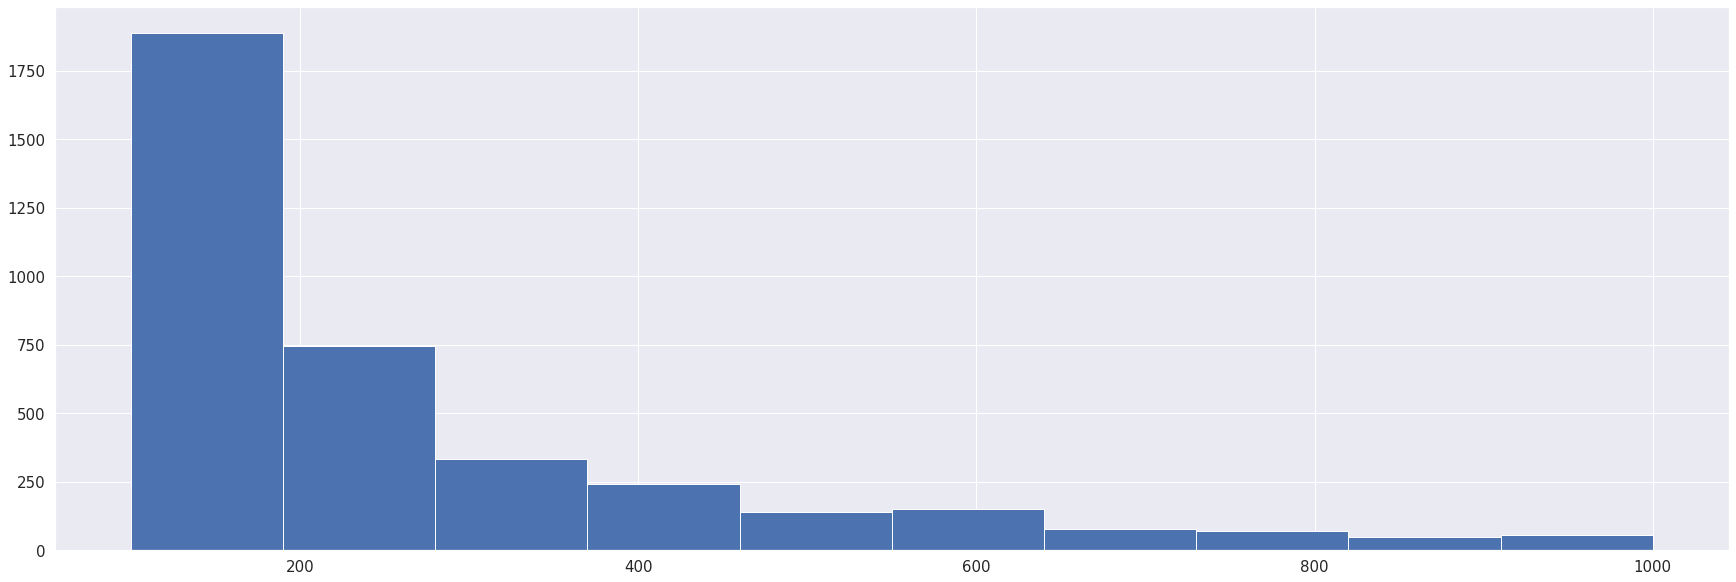

In [124]:
may03_chart.pvs_y.hist(range=(100, 1000))

In [119]:
may03_chart.pvs_y.describe()

count      4199.000000
mean        930.479162
std        6500.366085
min         101.000000
25%         136.000000
50%         205.000000
75%         428.500000
max      205094.000000
Name: pvs_y, dtype: float64

In [134]:
may03_chart.to_csv("may03_chart.csv", index=False)

**Topic scoring**

* Aggregate GA metrics per topic
* Scale GA metrics using MinMaxScaler
* Apply weights
* Add them up

| GA metrics      | Weight |
| ----------- | ----------- |
| Number of unique articles per topic      | 1.5       |
| Pageviews   | 0.5        |
| Avg. time on pg.   | 2        |
| Avg. scroll   | 1        |

In [85]:
def calculate_topic_metrics(sc_df):
    '''
    Aggregate GA metrics at topic level
    '''
    
    score_df = sc_df.groupby('Topic').agg({'topic_words':'max',
                                           'content_natid':'nunique',
                                           'pvs_y':'sum', 
                                           'avg_time_on_page':'mean', 
                                           'avg_scroll':'mean'}).reset_index().rename(columns={'content_natid':'art_count', 
                                                                                               'pvs_y': 'pvs'})
    # drop the noise topic
    score_df = score_df[score_df.Topic!=-1]
    return score_df

In [86]:
may03_sc = calculate_topic_metrics(may03_sc)
may04_sc = calculate_topic_metrics(may04_sc)
may05_sc = calculate_topic_metrics(may05_sc)
may06_sc = calculate_topic_metrics(may06_sc)
may07_sc = calculate_topic_metrics(may07_sc)

In [87]:
may03_sc.head(5)

,Topic,topic_words,art_count,pvs,avg_time_on_page,avg_scroll
1,0,"10 states, average annual, annual wage, salaries, occupational, therapist salary",29,7233,75.942211,0.441175
2,1,"million viewers, 000 viewers, fox news, msnbc, cable news, prime time",5,1472,86.006484,0.446392
3,2,"pink moon, sky, supermoons, super pink, sun, blood moon",12,8561,90.543466,0.369044
4,3,"def, aew, nxt, wrestlemania, smackdown, live events",8,2183,91.864269,0.442752
5,4,"packers, quarterback, rodgers, round, nfl draft, green bay",11,7489,115.937136,0.475377


In [113]:
# save this in excel
may03_sc

,Topic,topic_words,art_count,pvs,avg_time_on_page,avg_scroll,date
1,0,"10 states, average annual, annual wage, salaries, occupational, therapist salary",29,7233,75.942211,0.441175,2021-05-03
2,1,"million viewers, 000 viewers, fox news, msnbc, cable news, prime time",5,1472,86.006484,0.446392,2021-05-03
3,2,"pink moon, sky, supermoons, super pink, sun, blood moon",12,8561,90.543466,0.369044,2021-05-03
4,3,"def, aew, nxt, wrestlemania, smackdown, live events",8,2183,91.864269,0.442752,2021-05-03
5,4,"packers, quarterback, rodgers, round, nfl draft, green bay",11,7489,115.937136,0.475377,2021-05-03
...,...,...,...,...,...,...,...
305,316,"kabat zinn, mindfulness, ikigai, kelly, decisions, goal setting",5,1495,176.523616,0.442845,2021-05-03
306,317,"conflict, happiness, nonverbal cues, gestures, strategic thinkers, body language",3,1157,108.315344,0.348553,2021-05-03
307,318,"coachable, unspoken rules, communicators, ask, ng, leadership",1,241,106.336100,0.473029,2021-05-03
308,319,"overthinking, psychological safety, smart people, feelings, emotions, therapy",10,2219,124.350236,0.487456,2021-05-03


In [88]:
from sklearn.preprocessing import MinMaxScaler

cols_to_scale = may03_sc.columns.tolist()[2:]

weighting = [
    1.5, # article count per topic
    0.5, # pageviews
    2, # avg time on page
    1.5 # avg scroll
]
    
def calc_weighted_sum(score_df):
    
    # scale cols
    scaler = MinMaxScaler()
    score_df[cols_to_scale] = scaler.fit_transform(score_df[cols_to_scale])
    
    # give weights to cols
    for col, weight in zip(score_df.columns.tolist()[2:], weighting):
        score_df[col] = score_df[col] * weight
    # sum
    score_df['score'] = score_df.iloc[:, 1:].sum(axis=1)
    # sort
    score_df = score_df.sort_values(by='score', 
                                       ascending=False).reset_index(drop=True)
    
    return score_df

In [89]:
may03_score = may03_sc.copy()
may04_score = may04_sc.copy()
may05_score = may05_sc.copy()
may06_score = may06_sc.copy()
may07_score = may07_sc.copy()

may03_score = calc_weighted_sum(may03_score)
may04_score = calc_weighted_sum(may04_score)
may05_score = calc_weighted_sum(may05_score)
may06_score = calc_weighted_sum(may06_score)
may07_score = calc_weighted_sum(may07_score)

In [25]:
# OLD
# may03_score.head(5)

,Topic,topic_words,art_count,pvs,avg_time_on_page,avg_scroll,score
0,71,"games, players, destiny, pokemon, damage, outriders",1.500000,0.233723,0.578530,0.701123,3.013376
1,35,"whatsapp, privacy, facebook, users, google, end end",1.125000,0.473752,0.824595,0.564633,2.987979
2,50,"spa, park, town, beaches, guests, islands",1.108696,0.137263,0.749621,0.781009,2.776589
3,40,"international living, expats, cost living, panama, beaches, says stevens",0.228261,0.382528,1.131850,0.886879,2.629518
4,260,"culture, leadership, values, hr, employees, team members",0.456522,0.021508,1.369025,0.706933,2.553988


In [90]:
may03_score.head(5)

,Topic,topic_words,art_count,pvs,avg_time_on_page,avg_scroll,score
0,44,"whatsapp, privacy, facebook, users, google, email",1.500000,0.470013,0.941054,0.730619,3.641685
1,62,"park, town, spa, beaches, islands, travel",1.257353,0.126391,0.850403,1.065676,3.299823
2,45,"international living, expats, cost living, panama, beaches, says stevens",0.308824,0.382526,1.221923,1.212732,3.126004
3,276,"growth mindset, remote workers, managers, entrepreneurs born, asynchronous, handbooks",0.000000,0.000539,1.597433,1.284034,2.882005
4,132,"brockman, garg, justice, hsieh, byrne, court",1.125000,0.061610,0.831715,0.835238,2.853563


In [93]:
may03_score.sort_values("Topic")

,Topic,topic_words,art_count,pvs,avg_time_on_page,avg_scroll,score
97,0,"10 states, average annual, annual wage, salaries, occupational, therapist salary",0.617647,0.021704,0.616606,0.895560,2.151517
227,1,"million viewers, 000 viewers, fox news, msnbc, cable news, prime time",0.088235,0.004165,0.708689,0.912052,1.713141
236,2,"pink moon, sky, supermoons, super pink, sun, blood moon",0.242647,0.025746,0.750200,0.667528,1.686122
195,3,"def, aew, nxt, wrestlemania, smackdown, live events",0.154412,0.006329,0.762285,0.900546,1.823572
79,4,"packers, quarterback, rodgers, round, nfl draft, green bay",0.220588,0.022483,0.982539,1.003685,2.229296
...,...,...,...,...,...,...,...
29,316,"kabat zinn, mindfulness, ikigai, kelly, decisions, goal setting",0.088235,0.004235,1.536875,0.900839,2.530183
265,317,"conflict, happiness, nonverbal cues, gestures, strategic thinkers, body language",0.044118,0.003206,0.912804,0.602750,1.562877
174,318,"coachable, unspoken rules, communicators, ask, ng, leadership",0.000000,0.000417,0.894695,0.996262,1.891374
60,319,"overthinking, psychological safety, smart people, feelings, emotions, therapy",0.198529,0.006439,1.059515,1.041870,2.306353


In [23]:
# # OLD
# import seaborn as sns

# may03_show10 = may03_score.head(10).copy()

# cm = sns.light_palette(
#     "seagreen",
#     as_cmap=True,
#     reverse=False
# )

# may03_show10 = may03_show10.style.background_gradient(cmap=cm)

# may03_show10

,Topic,topic_words,art_count,pvs,avg_time_on_page,avg_scroll,score
0,71,"games, players, destiny, pokemon, damage, outriders",1.500000,0.233723,0.578530,0.701123,3.013376
1,35,"whatsapp, privacy, facebook, users, google, end end",1.125000,0.473752,0.824595,0.564633,2.987979
2,50,"spa, park, town, beaches, guests, islands",1.108696,0.137263,0.749621,0.781009,2.776589
3,40,"international living, expats, cost living, panama, beaches, says stevens",0.228261,0.382528,1.131850,0.886879,2.629518
4,260,"culture, leadership, values, hr, employees, team members",0.456522,0.021508,1.369025,0.706933,2.553988
5,247,"managers, entrepreneurs born, asynchronous, handbooks, bock, employee handbook",0.000000,0.000548,1.550830,0.935891,2.487270
6,162,"howes, faulkner, lenin, epics, propaganda, laughs",0.000000,0.000231,2.000000,0.483615,2.483846
7,114,"roth ira, spouse, social security, inherited, beneficiary, contribution",0.065217,0.003093,1.419822,0.888583,2.376715
8,19,"representations warranties, employee, agreement, spacs, charity, llc",0.130435,0.003842,1.628559,0.578157,2.340993
9,262,"confidential information, nda, interview questions, feedback, recipient, negotiations",0.032609,0.008077,1.668254,0.603018,2.311957


In [91]:
import seaborn as sns

may03_show10 = may03_score.head(10).copy()

cm = sns.light_palette(
    "seagreen",
    as_cmap=True,
    reverse=False
)

may03_show10 = may03_show10.style.background_gradient(cmap=cm)

may03_show10

,Topic,topic_words,art_count,pvs,avg_time_on_page,avg_scroll,score
0,44,"whatsapp, privacy, facebook, users, google, email",1.500000,0.470013,0.941054,0.730619,3.641685
1,62,"park, town, spa, beaches, islands, travel",1.257353,0.126391,0.850403,1.065676,3.299823
2,45,"international living, expats, cost living, panama, beaches, says stevens",0.308824,0.382526,1.221923,1.212732,3.126004
3,276,"growth mindset, remote workers, managers, entrepreneurs born, asynchronous, handbooks",0.000000,0.000539,1.597433,1.284034,2.882005
4,132,"brockman, garg, justice, hsieh, byrne, court",1.125000,0.061610,0.831715,0.835238,2.853563
5,280,"project management, scenario planning, flamini, focal issue, flat structure, ally",0.022059,0.000996,1.653486,1.175043,2.851583
6,305,"hiring managers, candidates, diversity inclusion, bias, inclusive leaders, interviewers",0.022059,0.000959,1.661444,1.165942,2.850404
7,120,"appraisal, contingency, seller, needs business, mortgage, closing",0.044118,0.002232,1.449406,1.353067,2.848823
8,299,"culture, leadership, hr, diversity, team members, skills",0.441176,0.013919,1.419041,0.967399,2.841536
9,54,"jeans, dress, gift, jewelry, towels, moms",0.794118,0.041730,0.819054,1.149993,2.804893


In [24]:
# TODO: - scale the score to 0-100 for better representation

# --- EDA ---

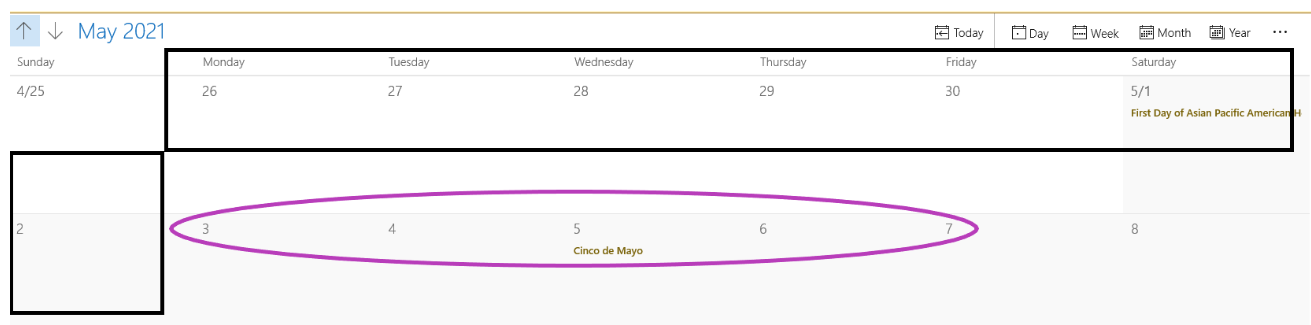

### Training 

* Date range 7 days -- Apr 26 (monday) till May 02 (sunday)

* Eligible pool = articles with pvs threshold = 7,238 articles
    * **Distinct topics including -1 for noise :: 277**

### Predict topics 

* Date range -- may 3 (monday) till May 07 (friday)
* Eligible pool = articles with pvs > 100

In [94]:
print("Eligible articles:")
print("May 3 -", pred_may03_inspect.shape)
print("May 4 -", pred_may04_inspect.shape)
print("May 5 -", pred_may05_inspect.shape)
print("May 6 -", pred_may06_inspect.shape)
print("May 7 -", pred_may07_inspect.shape)

Eligible articles:
May 3 - (4199, 15)
May 4 - (4223, 15)
May 5 - (4160, 15)
May 6 - (4063, 15)
May 7 - (3630, 15)


In [95]:
print("Topic assigned:")
print("May 3 -",len(pred_may03_inspect.Topic.unique()))
print("May 4 -",len(pred_may04_inspect.Topic.unique()))
print("May 5 -",len(pred_may05_inspect.Topic.unique()))
print("May 6 -",len(pred_may06_inspect.Topic.unique()))
print("May 7 -",len(pred_may07_inspect.Topic.unique()))

Topic assigned:
May 3 - 310
May 4 - 298
May 5 - 311
May 6 - 292
May 7 - 287


**Observation**:
* Topic quality - determined by quantitative metrics (cos similarity, dbcv score) and some manual inspection - suggests good/coherent clustering overall 

In [96]:
common_34 = pd.merge(pd.merge(pd.merge(pd.merge(may03_sc[["Topic"]], may04_sc[["Topic"]], on="Topic", how="inner"), may05_sc[["Topic"]], on="Topic", how="inner"), 
                     may06_sc[["Topic"]], on="Topic", how="inner"), may07_sc[["Topic"]], on="Topic", how="inner")

print("Common topics across 5 days - ", len(common_34))

Common topics across 5 days -  257


**Observation:**
* On avg. 56% - 60% articles get clustered into a topic each day and rest is deemed as noise by HDBSCAN 

In [97]:
print("Perc of articles CLUSTERED - ", round((1 - noise_perc[noise_perc.Topic==-1].Size[1]/noise_perc.Size.sum())*100))
print("Perc of articles NOISE - ", round((noise_perc[noise_perc.Topic==-1].Size[1]/noise_perc.Size.sum())*100))

NameError: name 'noise_perc' is not defined

**Observation:**
* On avg. 9 articles form a topic

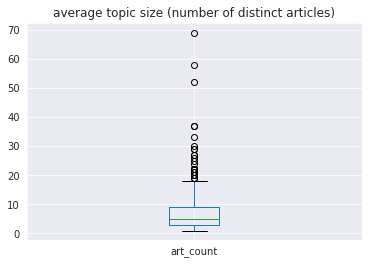

In [98]:
may03_sc.boxplot('art_count')
title_boxplot = 'average topic size (number of distinct articles)'
plt.title( title_boxplot )
plt.suptitle('')
plt.show()

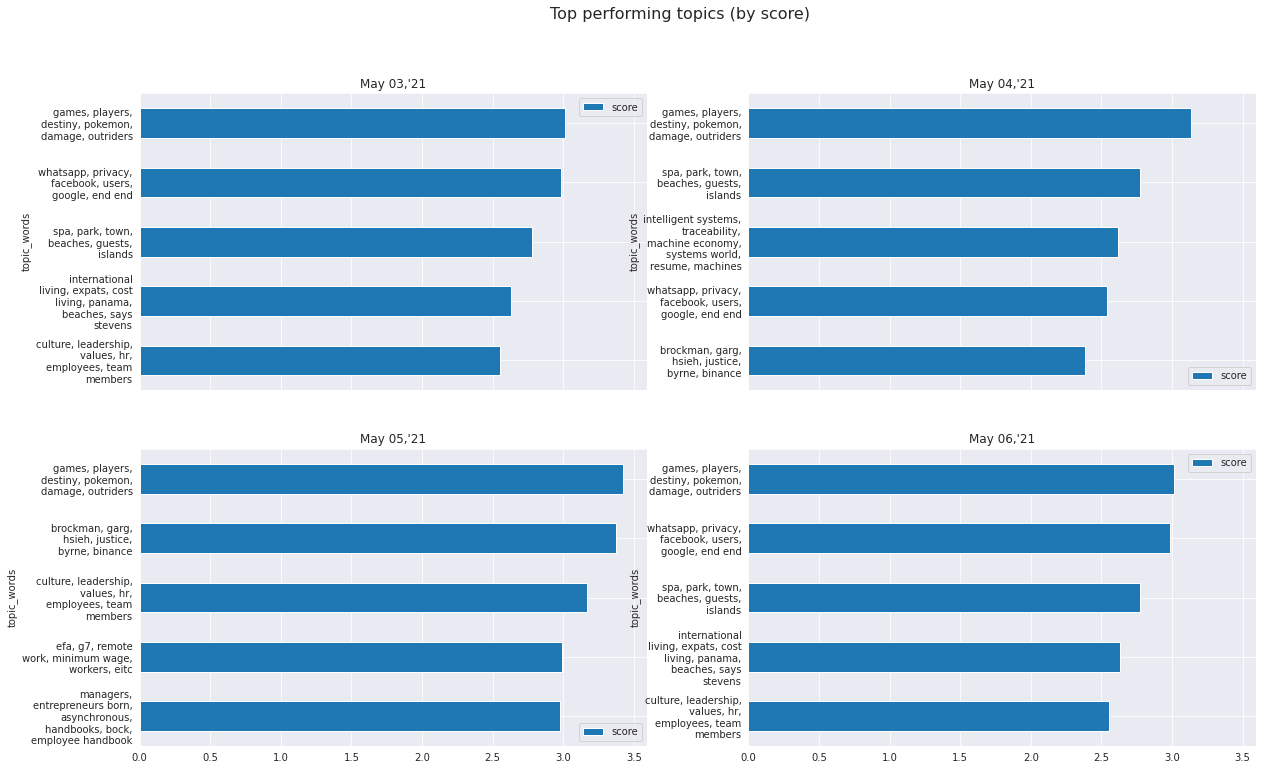

In [26]:
# OLD
# from textwrap import wrap

# may03_top5 = may03_score.head(5)
# may03_top5.sort_values('score',inplace=True)
# may03_labels = [ '\n'.join(wrap(l, 20)) for l in may03_top5.topic_words]

# may04_top5 = may04_score.head(5)
# may04_top5.sort_values('score',inplace=True)
# may04_labels = [ '\n'.join(wrap(l, 20)) for l in may04_top5.topic_words]

# may05_top5 = may05_score.head(5)
# may05_top5.sort_values('score',inplace=True)
# may05_labels = [ '\n'.join(wrap(l, 20)) for l in may05_top5.topic_words]

# may06_top5 = may03_score.head(5)
# may06_top5.sort_values('score',inplace=True)
# may06_labels = [ '\n'.join(wrap(l, 20)) for l in may06_top5.topic_words]

# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,12), sharex=True) 

# fig.suptitle('Top performing topics (by score)', fontsize=16)

# may03_top5.plot.barh(x='topic_words', y='score', ax = axes[0][0], title="May 03,'21")
# axes[0][0].set_yticklabels(may03_labels)

# may04_top5.plot.barh(x='topic_words', y='score', ax = axes[0][1], title="May 04,'21")
# axes[0][1].set_yticklabels(may04_labels)

# may05_top5.plot.barh(x='topic_words', y='score', ax = axes[1][0], title="May 05,'21")
# axes[1][0].set_yticklabels(may05_labels)

# may06_top5.plot.barh(x='topic_words', y='score', ax = axes[1][1], title="May 06,'21")
# axes[1][1].set_yticklabels(may06_labels)

# plt.show()

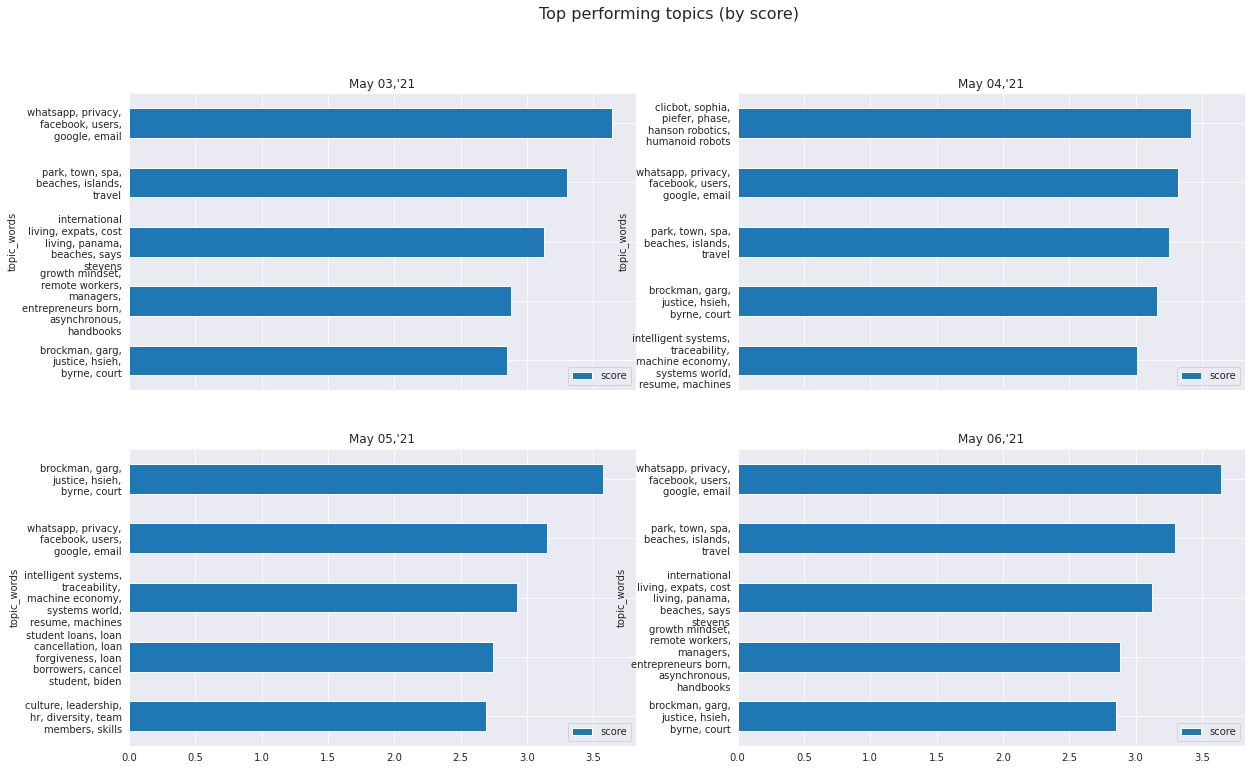

In [99]:
from textwrap import wrap

may03_top5 = may03_score.head(5)
may03_top5.sort_values('score',inplace=True)
may03_labels = [ '\n'.join(wrap(l, 20)) for l in may03_top5.topic_words]

may04_top5 = may04_score.head(5)
may04_top5.sort_values('score',inplace=True)
may04_labels = [ '\n'.join(wrap(l, 20)) for l in may04_top5.topic_words]

may05_top5 = may05_score.head(5)
may05_top5.sort_values('score',inplace=True)
may05_labels = [ '\n'.join(wrap(l, 20)) for l in may05_top5.topic_words]

may06_top5 = may03_score.head(5)
may06_top5.sort_values('score',inplace=True)
may06_labels = [ '\n'.join(wrap(l, 20)) for l in may06_top5.topic_words]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,12), sharex=True) 

fig.suptitle('Top performing topics (by score)', fontsize=16)

may03_top5.plot.barh(x='topic_words', y='score', ax = axes[0][0], title="May 03,'21")
axes[0][0].set_yticklabels(may03_labels)

may04_top5.plot.barh(x='topic_words', y='score', ax = axes[0][1], title="May 04,'21")
axes[0][1].set_yticklabels(may04_labels)

may05_top5.plot.barh(x='topic_words', y='score', ax = axes[1][0], title="May 05,'21")
axes[1][0].set_yticklabels(may05_labels)

may06_top5.plot.barh(x='topic_words', y='score', ax = axes[1][1], title="May 06,'21")
axes[1][1].set_yticklabels(may06_labels)

plt.show()

In [103]:
may03_sc["date"] = "2021-05-03"
may03_sc["date"] = pd.to_datetime(may03_sc["date"])

may04_sc["date"] = "2021-05-04"
may04_sc["date"] = pd.to_datetime(may04_sc["date"])

may05_sc["date"] = "2021-05-05"
may05_sc["date"] = pd.to_datetime(may05_sc["date"])

may06_sc["date"] = "2021-05-06"
may06_sc["date"] = pd.to_datetime(may06_sc["date"])

may07_sc["date"] = "2021-05-07"
may07_sc["date"] = pd.to_datetime(may07_sc["date"])


sample_topics = [149, 114, 124, 93, 8]
may03_sample_topics = may03_sc[may03_sc.Topic.isin(sample_topics)]
may04_sample_topics = may04_sc[may04_sc.Topic.isin(sample_topics)]
may05_sample_topics = may05_sc[may05_sc.Topic.isin(sample_topics)]
may06_sample_topics = may06_sc[may06_sc.Topic.isin(sample_topics)]
may07_sample_topics = may07_sc[may07_sc.Topic.isin(sample_topics)]

combined = pd.concat([may03_sample_topics, may04_sample_topics, may05_sample_topics, may06_sample_topics, may07_sample_topics])
combined['date'] = combined['date'].dt.date

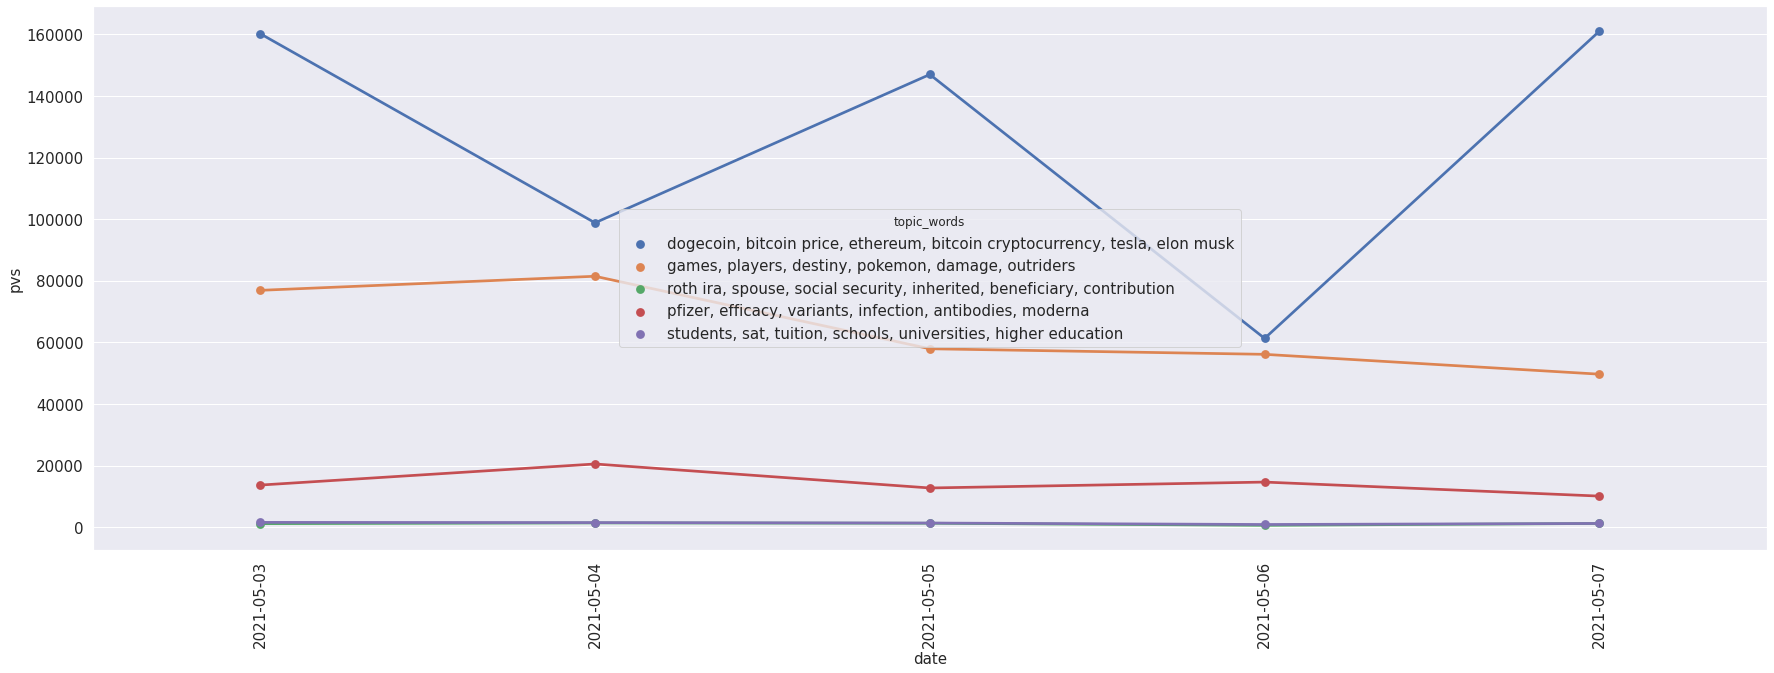

In [83]:
# OLD
# import seaborn as sns

# rc={'xtick.labelsize': 15, 'ytick.labelsize': 15, 'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 15.0, 
#     'axes.titlesize': 15, "figure.figsize": [30, 10]}
# sns.set(rc=rc)

# g = sns.pointplot(ci = None, x = combined["date"], y = combined["pvs"], hue = combined["topic_words"])
# plt.xticks(rotation=90)
# plt.show()

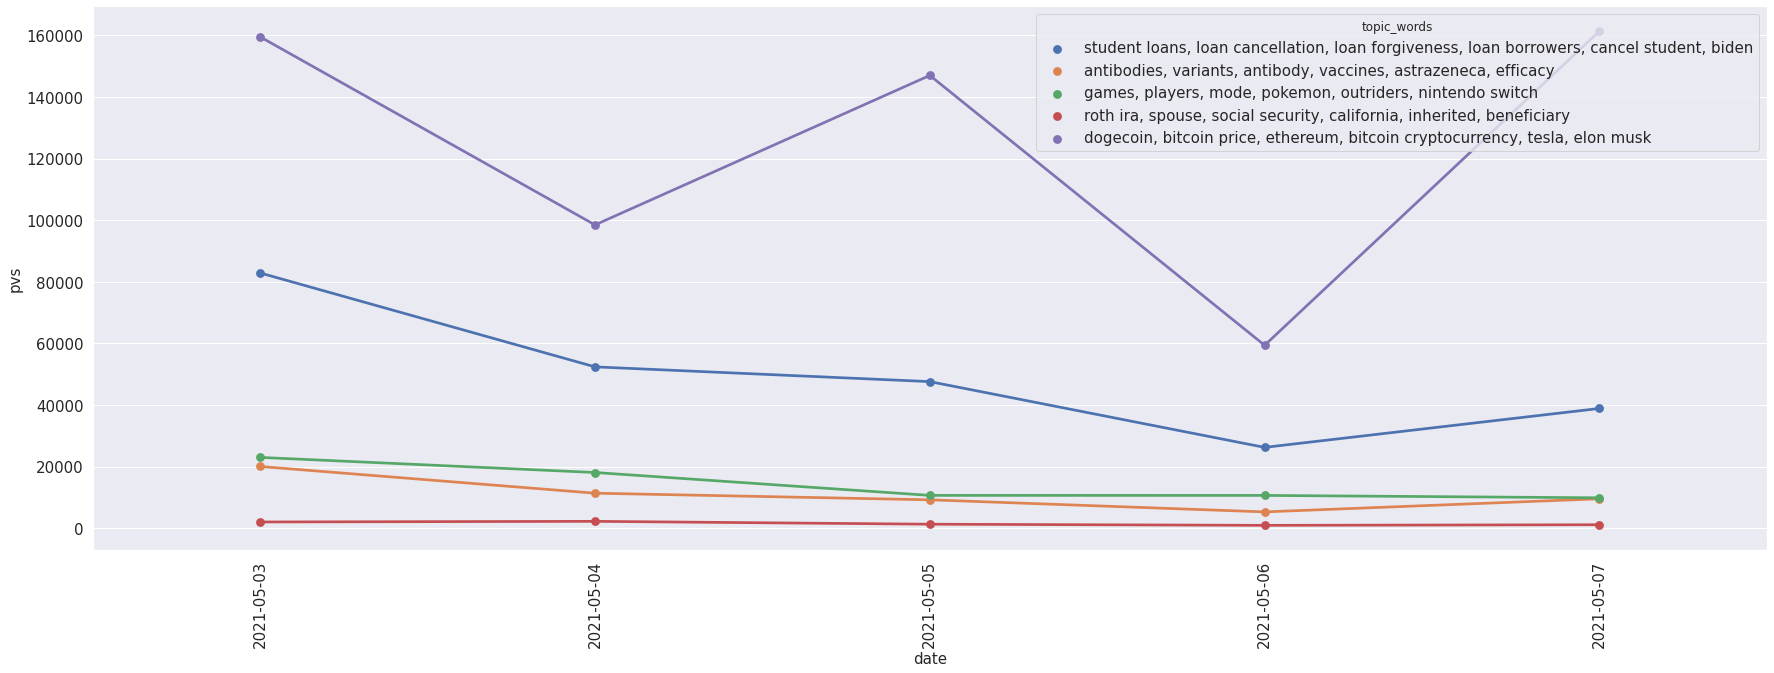

In [104]:
import seaborn as sns

rc={'xtick.labelsize': 15, 'ytick.labelsize': 15, 'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 15.0, 
    'axes.titlesize': 15, "figure.figsize": [30, 10]}
sns.set(rc=rc)

g = sns.pointplot(ci = None, x = combined["date"], y = combined["pvs"], hue = combined["topic_words"])
plt.xticks(rotation=90)
plt.show()

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2021-05-03'),
  Text(1, 0, '2021-05-04'),
  Text(2, 0, '2021-05-05'),
  Text(3, 0, '2021-05-06'),
  Text(4, 0, '2021-05-07')])

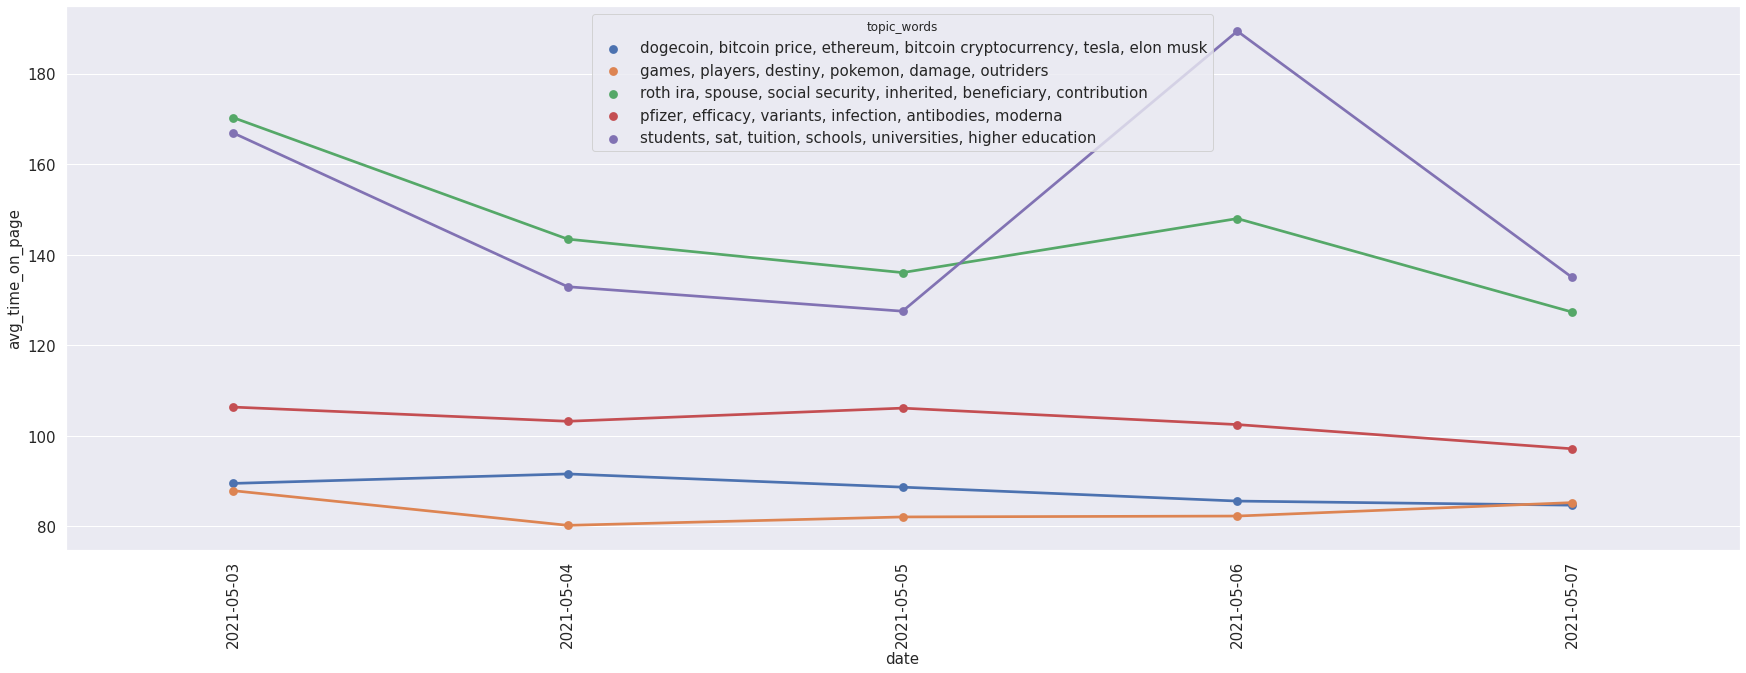

In [48]:
import seaborn as sns

rc={'xtick.labelsize': 15, 'ytick.labelsize': 15, 'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 15.0, 
    'axes.titlesize': 15, "figure.figsize": [30, 10]}
sns.set(rc=rc)

g = sns.pointplot(ci = None, x = combined["date"], y = combined["avg_time_on_page"], hue = combined["topic_words"])
plt.xticks(rotation=90)
plt.show()

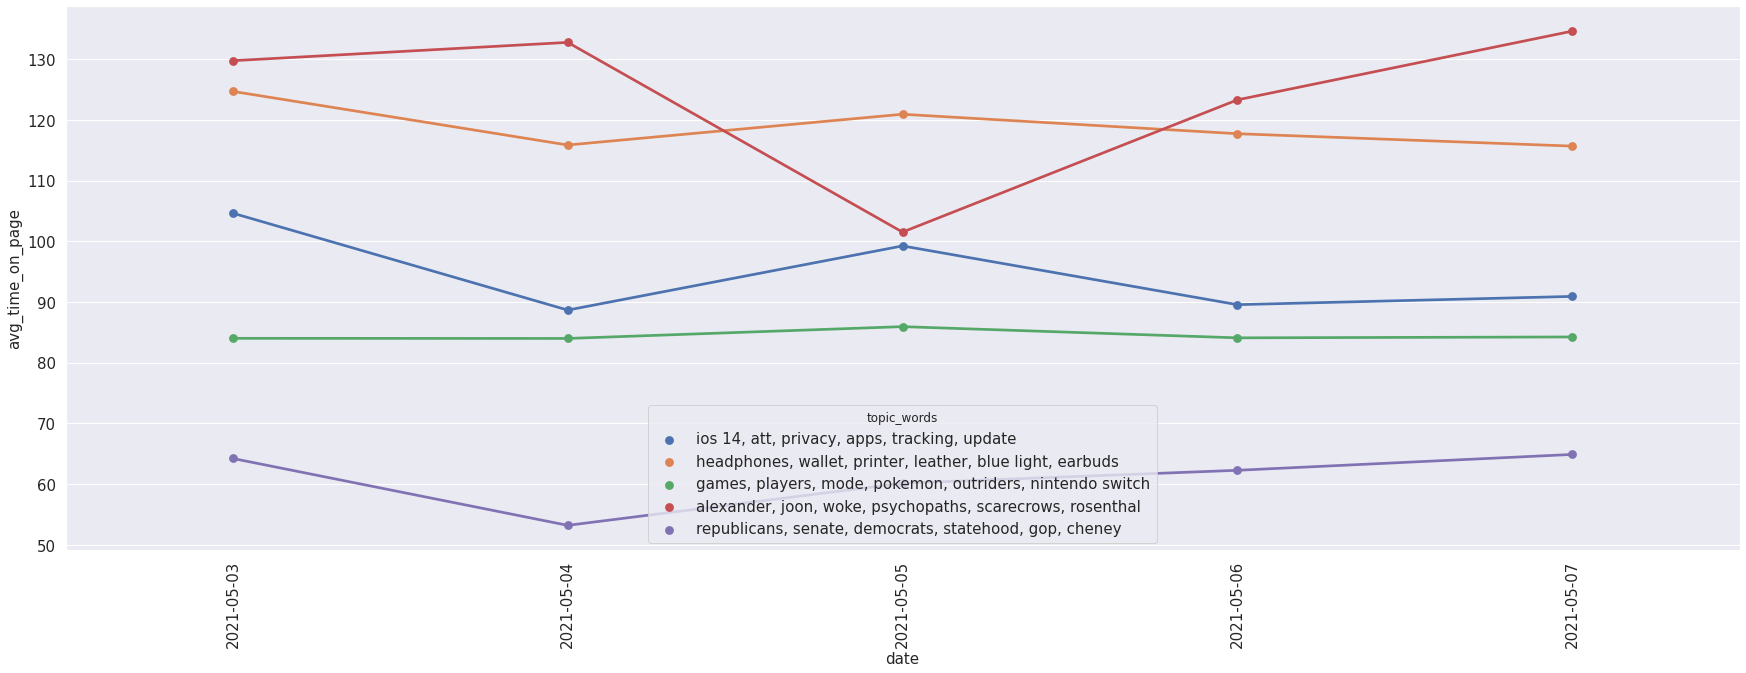

In [102]:
import seaborn as sns

rc={'xtick.labelsize': 15, 'ytick.labelsize': 15, 'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 15.0, 
    'axes.titlesize': 15, "figure.figsize": [30, 10]}
sns.set(rc=rc)

g = sns.pointplot(ci = None, x = combined["date"], y = combined["avg_time_on_page"], hue = combined["topic_words"])
plt.xticks(rotation=90)
plt.show()

In [ ]:
social traffics, search, referral sources

use probability as weight -- weight articles more by prob and consider for tf-idf
# generate data
# improve noise ratio

**Next steps:**

* review production workflow proposal
* implement the workflow